<a href="https://colab.research.google.com/github/rahul13ramesh/cis520-dataset/blob/master/Unsupervised_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIS-520 Project -[What's cooking](https://www.kaggle.com/c/whats-cooking-kernels-only)

* This notebook looks at the Kaggle contest *What's cooking*. We tackle a supervised and unsupervised learning problem using this dataset
* The inputs are a collection of words and hence a key aspect of this problem is to convert the collection of words into a finite dimensional feature

In [1]:
!pip install pywaffle
!git clone https://github.com/amueller/word_cloud.git
!cd word_cloud && pip install .

     |████████████████████████████████| 532kB 2.8MB/s 
Cloning into 'word_cloud'...
remote: Enumerating objects: 378, done.
remote: Counting objects: 100% (378/378), done.
remote: Compressing objects: 100% (204/204), done.
remote: Total 4070 (delta 202), reused 317 (delta 163), pack-reused 3692
Receiving objects: 100% (4070/4070), 77.39 MiB | 13.97 MiB/s, done.
Resolving deltas: 100% (2258/2258), done.
Processing /content/word_cloud
  Created wheel for wordcloud: filename=wordcloud-1.6.0.post1+g8217e20-cp36-cp36m-linux_x86_64.whl size=335569 sha256=910f3223c303a94545d521f68f8a13aa314943e84fdd714a0d4beb7a6f6416bb
  Stored in directory: /tmp/pip-ephem-wheel-cache-v84sct1e/wheels/c9/9e/fe/b14c026a2af072dcf59543bce68dcdfff8a5362e6bb11242d9
Successfully built wordcloud
  Found existing installation: wordcloud 1.5.0
    Uninstalling wordcloud-1.5.0:
      Successfully uninstalled wordcloud-1.5.0


In [0]:
import numpy as np
import pandas as pd
import urllib
import matplotlib.pyplot as plt
import json
import unicodedata
import re
import seaborn as sns
from gensim.models import word2vec
from gensim.models import KeyedVectors
import nltk
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from pywaffle import Waffle

In [3]:
!wget https://raw.githubusercontent.com/rahul13ramesh/cis520-dataset/master/test.json
!wget https://raw.githubusercontent.com/rahul13ramesh/cis520-dataset/master/train.json

--2019-12-08 17:01:20--  https://raw.githubusercontent.com/rahul13ramesh/cis520-dataset/master/test.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2844086 (2.7M) [text/plain]
Saving to: ‘test.json’

test.json           100%[===================>]   2.71M  --.-KB/s    in 0.1s    

2019-12-08 17:01:20 (26.1 MB/s) - ‘test.json’ saved [2844086/2844086]

--2019-12-08 17:01:24--  https://raw.githubusercontent.com/rahul13ramesh/cis520-dataset/master/train.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12415067 (12M) [text/plain]
Saving 

# Loading dataset
We load the dataset and display a single entry from this dataset

In [0]:
with open("test.json", "r") as f:
    test_data = json.load(f)
with open("train.json", "r") as f:
    train_data = json.load(f)
train_data_df = pd.DataFrame(train_data)
test_data_df = pd.DataFrame(test_data)

Example from dataset

In [5]:
train_data[0]

{'cuisine': 'greek',
 'id': 10259,
 'ingredients': ['romaine lettuce',
  'black olives',
  'grape tomatoes',
  'garlic',
  'pepper',
  'purple onion',
  'seasoning',
  'garbanzo beans',
  'feta cheese crumbles']}

In [0]:
def create_train_test_data(train_data_df, test_data_df):
  """
  Splits the original training and test data
  """
  train_recepies = [] 
  train_targets = []
  for ig_item in train_data_df['ingredients']:
      train_recepies.append(ig_item)
  for cuisine_item in train_data_df['cuisine']:
      train_targets.append(cuisine_item)

  # create test data only, no targets
  test_recepies = []
  for ig_item in test_data_df['ingredients']:
      test_recepies.append(ig_item)
  return train_recepies, train_targets, test_recepies

In [7]:
train_features, train_targets, test_features = create_train_test_data(train_data_df, test_data_df)
print(train_targets[0:5])

['greek', 'southern_us', 'filipino', 'indian', 'indian']


#### Remove small receipies, special characters, quantity classifiers (inch, oz etc.)

This is the key-preprocessing function. The data is processed to contain only lower case alphabets and spaces. Additional features are added based on number of ingredients/characters/occurrence of special characters etc.


In [8]:
def process_features(features, targets, mode="train"):
    processed_recipe = []
    processed_cuisine = []
    count_len = 0

    for idx, recipe in enumerate(features):
        processed_ingredient = []

        # Convert to lower case
        if mode=='train':
            cuisine_lower = targets[idx].lower()

        cur_features = {}
        ingredient_all = ' '.join(recipe)

        # f1) Add feature for number of ingredients
        if len(recipe) <= 2:
            count_len += 1
            continue
        cur_features["num_ingredients"] = len(recipe)

        # f2) Change accented characters to ascii characters
        accented_char_set= ["â", "ç", "è", "é", "í", "î", "ú", "’"]
        cur_features["accented"] = 0
        if 1 in [c in ingredient_all for c in accented_char_set]:
            cur_features["accented"] = 1

        # f3) Add feature for measurement units
        measurement_words = ["pound", "kg", "lb", "oz", "ounc", "inch"]
        cur_features["measurement"] = 0
        if np.any([w in ingredient_all for w in measurement_words]):
            cur_features["measurement"] = 1

        # f4) Symbols
        cur_features["symbol"] = 0
        if ("™" in ingredient_all) or ("®" in ingredient_all) or ("!" in ingredient_all):
            cur_features["symbol"] = 1

        # f5) Feature for numbers
        cur_features["number"] = 0
        if any(char.isdigit() for char in ingredient_all):
            cur_features["number"] = 1
            
        # f6) Feature for percentage
        cur_features["percentage"] = 0
        if "%" in ingredient_all:
            cur_features["percentage"] = 1

        # p1) Convert to lower case
        ingredient_all = ingredient_all.lower()
        # p2) Change accented characters to ascii characters
        ingredient_all = unicodedata.normalize('NFD', ingredient_all).encode('ascii', 'ignore')
        ingredient_all = ingredient_all.decode('ascii')
        # p3) Remove measurement units
        ingredient_all = re.sub((r'\b(pound|kg|lb|oz|ounc|inch)\b'), ' ', ingredient_all) 
        # p4) Remove symbol
        ingredient_all = ingredient_all.replace("!", " ")
        ingredient_all = ingredient_all.replace("™", " ")
        ingredient_all = ingredient_all.replace("®", " ")
        # p5) Remove brackets
        ingredient_all = ingredient_all.replace("(", " ")
        ingredient_all = ingredient_all.replace(")", " ")
        # p6) Remove hyphens
        ingredient_all = ingredient_all.replace("-", " ")
        # p7) Remove numbers
        ingredient_all = re.sub("\d", " ", ingredient_all)
        # p8) Remove percentages and / (occur with numbers)
        ingredient_all = ingredient_all.replace("/", " ")
        ingredient_all = ingredient_all.replace("%", " ")

        # p9) Remove some more characters
        ingredient_all = ingredient_all.replace(".", " ")
        ingredient_all = ingredient_all.replace("€", " ")
        ingredient_all = ingredient_all.replace(",", " ")

        # p10) Handle apostrophe
        ingredient_all = ingredient_all.replace("’", "'")
        ingredient_all = ingredient_all.replace("'", "")

        # p11) Replace & with and
        ingredient_all = ingredient_all.replace("&", "and")

        ings = ' '.join(ingredient_all.split())
        cur_features["num_words"] = len(ingredient_all.split())

        processed_recipe.append((
                cur_features["num_words"], cur_features["num_ingredients"],
                cur_features["accented"], cur_features["measurement"],
                cur_features["symbol"], cur_features["number"],
                cur_features["percentage"], ings
            ))
        if mode=='train':
            processed_cuisine.append(cuisine_lower)
    
    print('Removed {} small recipe from input data'.format(count_len))
    if mode=='train':
        return processed_recipe, processed_cuisine
    else:
        return processed_recipe

processed_train_features, processed_train_target = process_features(train_features, train_targets, mode='train')
processed_test_features = process_features(test_features, train_targets,  mode='test') # just passing the targets, not using it while preprocessing test data


print(len(processed_train_target))
print(len(processed_train_features))

Removed 215 small recipe from input data
Removed 56 small recipe from input data
39559
39559


In [9]:
train_data = pd.DataFrame(processed_train_features)
test_data = pd.DataFrame(processed_test_features)

train_data.columns = ["num_words", "num_ingredients", "accented", "measurement", "symbol", "number", "percentage", "text"]
print(train_data.shape)

(39559, 8)


In [0]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def generate_bag_of_words(train_bin_vec, test_bin_vec):
    binarizer = CountVectorizer(analyzer = "word",  ngram_range = (1, 2), 
                                binary = False, tokenizer = None, preprocessor = None, 
                                stop_words = None,  min_df=0.001) 
    binarizer.fit([str(i[-1]) for i in train_bin_vec])
    binary_vector_tr = binarizer.transform([str(i[-1]) for i in train_bin_vec])
    binary_vector_te = binarizer.transform([str(i[-1]) for i in test_bin_vec])
    return binary_vector_tr, binary_vector_te, binarizer

def generate_tf_idf(train_bin_vec, test_bin_vec, bin=False, ngrammax=2,
                    use_idf=True, smooth_idf=True, sublinear_tf=False,
                    mindf=0.001):
    vectorizer = TfidfVectorizer(input="content", preprocessor=None, tokenizer=None, 
                                 analyzer="word", ngram_range=(1, ngrammax), min_df=mindf,
                                 binary=bin, norm="l2", use_idf=use_idf, smooth_idf=smooth_idf,
                                 sublinear_tf=sublinear_tf)
    vectorizer.fit([str(i[-1]) for i in train_bin_vec])
    binary_vector_tr = vectorizer.transform([str(i[-1]) for i in train_bin_vec])
    binary_vector_te = vectorizer.transform([str(i[-1]) for i in test_bin_vec])
    return binary_vector_tr, binary_vector_te, vectorizer


In [0]:
def merge_representation(train_features, vectorized_text):
    merged_dat = []
    for i in range(len(train_features)):
        merged_dat.append(np.concatenate((np.array(train_features[i][:-1]), vectorized_text[i])))
    return np.array(merged_dat)

train_rep, test_rep, binarizer = generate_tf_idf(processed_train_features, processed_test_features,
                                                 bin=False, ngrammax=1, use_idf=True, smooth_idf=True,
                                                 sublinear_tf=False, mindf=0.0001)


# train_rep = merge_representation(processed_train_features, train_rep.toarray())

In [12]:
print(train_rep[0].shape)

(1, 1983)


# Unsupervised learning

In [0]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder

In [0]:
kmeans = KMeans(n_clusters=6)
kmeans.fit(train_rep)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

Clustering the datapoints using K-means shows that the cuisines fall into different clusters

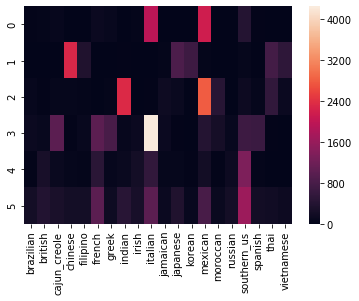

In [0]:
lab = kmeans.labels_
lb_en = LabelEncoder()
train_encoded = lb_en.fit_transform(processed_train_target)

kmean_map = np.zeros((6, 20))
for i in range(len(lab)):
    kmean_map[lab[i], train_encoded[i]] += 1

decoded_lb = lb_en.inverse_transform([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19])
index = list(decoded_lb)

kmean_map = pd.DataFrame(kmean_map)
kmean_map.columns =index
sns.heatmap(kmean_map)

In [0]:
pca = PCA(n_components=2)
tsne = TSNE(n_components=2)

The datapoints were reduced to lower dimensions using PCA and t-sne. The cuisine is represented by the average embeddings of all recipes in that cuisine. The plots show interesting patterns chinese and korean being similar, or irish and british being similar

      Component 1 Component 2         label
0       0.0137753   0.0185314  cajun_creole
1       -0.208435   -0.067693         greek
2       -0.107464    0.179499    vietnamese
3        0.463062 -0.00446232       italian
4       0.0083986   -0.216587         greek
...           ...         ...           ...
39554   0.0894365    0.118885    vietnamese
39555   -0.181259  -0.0111488   southern_us
39556    0.321125  0.00963139      jamaican
39557  -0.0750988   -0.176406       italian
39558  -0.0288914  -0.0173537       italian

[39559 rows x 3 columns]


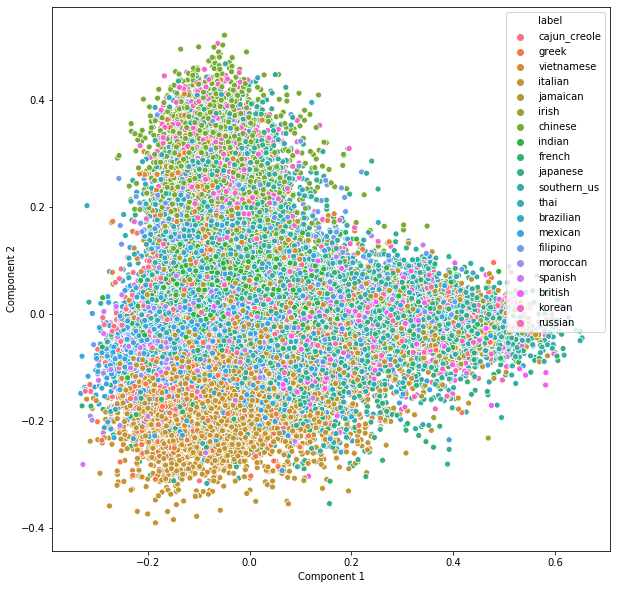

In [0]:
two_comp = np.array(pca.fit_transform(train_rep.toarray()))
ind = list(range(len(two_comp)))
np.random.shuffle(ind)
subsetlabel = [processed_train_target[i] for i in ind]
dat = pd.DataFrame([two_comp[ind, 0], two_comp[ind, 1], subsetlabel]).T
dat.columns = ["Component 1", "Component 2", "label"]
print(dat)
plt.figure(figsize=(10,10))
sns.scatterplot(x="Component 1", y="Component 2", hue="label", data=dat)

/usr/local/lib/python3.6/dist-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


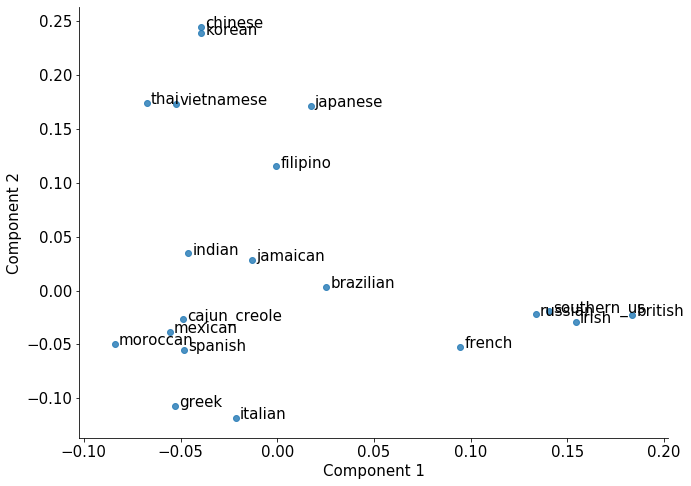

In [0]:
dat["Component 1"] = pd.to_numeric(dat["Component 1"])
dat["Component 2"] = pd.to_numeric(dat["Component 2"])
dat2 = dat.groupby("label").mean()
dat2["label"] = list(dat2.index)

ax = sns.lmplot('Component 1', 'Component 2', # Vertical axis
                data=dat2, # Data source
                fit_reg=False, # Don't fix a regression line
                size=7, aspect=1.4 ) # size and dimension

plt.rcParams.update({'font.size': 15})
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x'] + 0.002, point['y'] - 0.001, str(point['val']))

label_point(dat2["Component 1"], dat2["Component 2"], dat2["label"], plt.gca())


In [0]:
two_comp = np.array(tsne.fit_transform(train_rep.toarray()))
ind = list(range(len(two_comp)))
np.random.shuffle(ind)
subsetlabel = [processed_train_target[i] for i in ind]
dat = pd.DataFrame([two_comp[ind, 0], two_comp[ind, 1], subsetlabel]).T
dat.columns = ["Component 1", "Component 2", "label"]

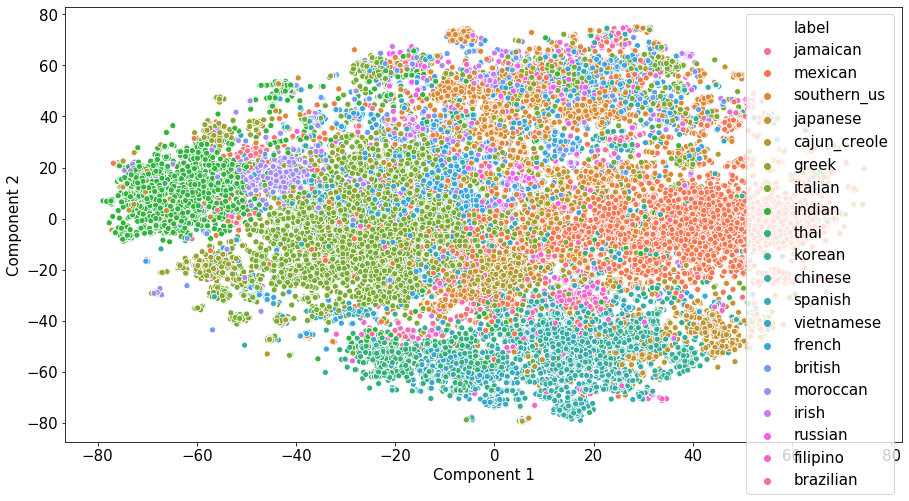

In [0]:
plt.figure(figsize=(15,8))
sns.scatterplot(x="Component 1", y="Component 2", hue="label", data=dat)

/usr/local/lib/python3.6/dist-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


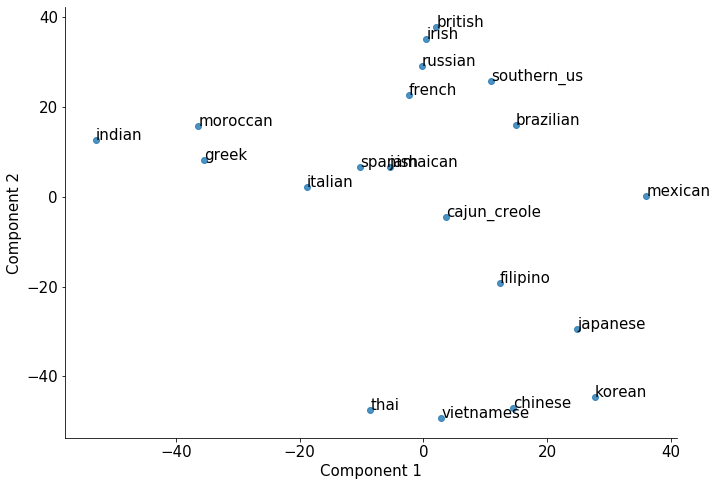

In [0]:
dat["Component 1"] = pd.to_numeric(dat["Component 1"])
dat["Component 2"] = pd.to_numeric(dat["Component 2"])
dat2 = dat.groupby("label").mean()
dat2["label"] = list(dat2.index)

ax = sns.lmplot('Component 1', 'Component 2', # Vertical axis
                data=dat2, # Data source
                fit_reg=False, # Don't fix a regression line
                size=7, aspect=1.4 ) # size and dimension

plt.rcParams.update({'font.size': 15})
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x'] + 0.002, point['y'] - 0.001, str(point['val']))

label_point(dat2["Component 1"], dat2["Component 2"], dat2["label"], plt.gca())

Finally, we look at LDA. We see the different topics that generate each recipe. Dairy items are found in one topic 1 while topic 0 has items commonly found in Italian/French cuisines. 

In [15]:
def generate_counts(train_bin_vec):
    binarizer = CountVectorizer(analyzer = "word",  ngram_range = (1, 1), 
                                binary = False, tokenizer = None, preprocessor = None, 
                                stop_words = None,  min_df=0.003, max_df=1.0) 
    binary_vec = binarizer.fit_transform([str(i[-1]) for i in train_bin_vec])
    return binary_vec, binarizer

def print_topics(model, count_vectorizer, n_top_words=10):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))

lda =  LatentDirichletAllocation(n_components=5)
count_data, binarizer = generate_counts(processed_train_features)
lda.fit(count_data)


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=5, n_jobs=None,
                          perp_tol=0.1, random_state=None,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=0)

In [16]:
print_topics(lda, binarizer, 30)


Topic #0:
pepper oil salt fresh olive ground garlic black lemon cloves parsley red wine tomatoes onions extra virgin leaves white juice dried chicken butter chopped thyme leaf dry vinegar onion water

Topic #1:
sugar flour butter salt all purpose eggs milk large baking water cream powder vanilla unsalted egg extract ground cinnamon white lemon brown yolks corn soda oil buttermilk whole orange juice

Topic #2:
cheese pepper chicken cream garlic ground salt tomatoes shredded onions sauce black parmesan oil green seasoning cheddar sour beans chopped fresh olive tortillas corn grated fat dried onion bell mozzarella

Topic #3:
sauce oil soy rice garlic pepper sugar onions sesame chicken water ginger salt green vinegar fresh white red vegetable pork carrots scallions ground corn starch brown black seeds sodium wine

Topic #4:
pepper cilantro salt fresh garlic lime ground oil juice powder chopped cumin onion onions green red chicken tomatoes chili chilies leaves black bell cloves vegetable c